# Building a Recommendation Engine from Scratch
Agenda today:
1. Different types of recommendation engines
2. __Building our own hotel recommendation system__
    - Package Installation
    - Package Import
    - Performing exploratory data analysis
    - Perform feature engineering
    - Make recommendation 
    - Compare our engines with others

In [1]:
# installing packages
# !pip install numpy
# !pip install pandas
# !pip install surprise
# !pip install nltk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import random
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

## 1. Reading in the data and a simple exploratory data analysis

In [4]:
data = pd.read_csv("hotels.csv", encoding="latin-1")

In [4]:
# check out the shape and top few observations of the data
print(data.shape)
data.head(2)

(152, 3)


,name,address,desc
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."


In [20]:
# count the common length of description
data['desc_leng'] = data.desc.apply(lambda x: len(x.split(" ")))

In [21]:
data.desc_leng.describe()

print("There are {} documents in total".format(data.desc_leng.describe()['count']))
print("The longest document has {} words".format(data.desc_leng.describe()['max']))
print("The shortest document has {} words".format(data.desc_leng.describe()['min']))

There are 152.0 documents in total
The longest document has 492.0 words
The shortest document has 16.0 words


Text(0, 0.5, 'number of documents')

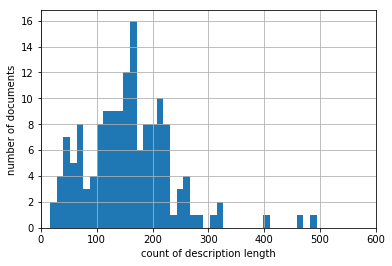

In [7]:
# examining the distribution of the document lengths
data.desc_leng.hist(bins = 40)
plt.xlim([0, 600])
plt.xlabel('count of description length')
plt.ylabel('number of documents')

This indicates that in our dataset, we have 152 hotels, and 3 features that describe our data: the names, the address, and the description.

In [8]:
# let's check out whether there is any duplicates
len(data.name.unique())

152

In [9]:
# getting the word frequency of the description
word_freq = data.desc.str.split(expand=True).stack().value_counts()

In [10]:
word_freq[:20]

the        1081
and        1037
a           590
of          521
to          464
in          416
Seattle     330
our         278
is          270
with        264
at          214
from        207
for         204
you         201
your        178
The         166
or          160
hotel       157
are         136
on          110
dtype: int64

<BarContainer object of 20 artists>

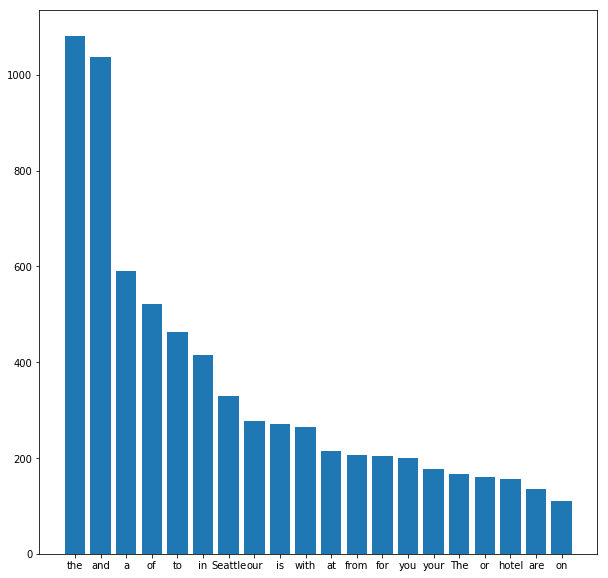

In [11]:
word_freq_top_20 = word_freq[:20]
word_freq_top_20 = dict(word_freq_top_20)
plt.figure(figsize=(10,10))
plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))

### Question: are these information going to be helpful to us when we are making recommendation? Why or why not?
We need to do some serious __data cleaning__!

In [12]:
# first of all, let us remove some useless words to see how our documents change
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [13]:
# we will then remove stop words from the hotel description to clean up the data 
data = data[['name','address','desc','desc_leng']]
data.head()

,name,address,desc,desc_leng
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the...",184
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat...",152
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ...",147
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...,150
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...,151


In [14]:
data['desc_cleaned'] = data.desc.apply(lambda x:x.lower())
data['without_stopwords'] = data['desc_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data.head()

,name,address,desc,desc_leng,desc_cleaned,without_stopwords
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the...",184,"located on the southern tip of lake union, the...","located southern tip lake union, hilton garden..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat...",152,"located in the city's vibrant core, the sherat...","located city's vibrant core, sheraton grand se..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ...",147,"located in the heart of downtown seattle, the ...","located heart downtown seattle, award-winning ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...,150,what?s near our hotel downtown seattle locatio...,what?s near hotel downtown seattle location? b...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...,151,situated amid incredible shopping and iconic a...,situated amid incredible shopping iconic attra...


In [15]:
# comparing description with stopwords and description without stopwords
print(data.without_stopwords[0])
print('------------------------')
print(data.desc[0])

located southern tip lake union, hilton garden inn seattle downtown hotel perfectly located business leisure. neighborhood home numerous major international companies including amazon, google bill & melinda gates foundation. wealth eclectic restaurants bars make area seattle one sought locals visitors. proximity lake union allows visitors take pacific northwest's majestic scenery enjoy outdoor activities like kayaking sailing. 2,000 sq. ft. versatile space complimentary business center. state-of-the-art a/v technology helpful staff guarantee conference, cocktail reception wedding success. refresh sparkling saltwater pool, energize latest equipment 24-hour fitness center. tastefully decorated flooded natural light, guest rooms suites offer everything need relax stay productive. unwind bar, enjoy american cuisine breakfast, lunch dinner restaurant. 24-hour pavilion pantry? stocks variety snacks, drinks sundries.
------------------------
Located on the southern tip of Lake Union, the Hilt

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
data['desc_cleaned'] = data['desc'].apply(clean_text)


In [ ]:
# compare the cleaned version of description
data['desc_cleaned'][0]

In [ ]:
word_freq_clean = data.desc_cleaned.str.split(expand=True).stack().value_counts()
word_freq_clean[:20]
plt.figure(figsize=(16,16))
plt.bar(range(len(word_freq_clean[:20])), dict(word_freq_clean[:20]).values(), tick_label=list(dict(word_freq_clean[:20]).keys()))


### Making recommendation

In [ ]:
data.set_index('name', inplace = True)

In [ ]:
# calculate cosine similarity between documents - we use tfidf
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data['desc_cleaned'])
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# examine the dense version of the documents 
#doc_term_matrix = tfidf_matrix.todense()
#df_term = pd.DataFrame(doc_term_matrix, 
                  #columns=tf.get_feature_names())
#df_term.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(df_term, df_term))

In [ ]:
indices = pd.Series(data.index)

In [ ]:
def recommendations(name, similarity_matrix = similarity_matrix):
    
    recommended_hotels = []
    
    # gettin the index of the hotel that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar hotels except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the names of the top 10 matching hotels
    for i in top_10_indexes:
        recommended_hotels.append(list(data.index)[i])
        
    return recommended_hotels

In [ ]:
# get the list of optional names 
data.index

In [ ]:
recomendations = input("what types of hotels would you like me to recommend for ya?")
recommendations(recomendations)
